#### Inspection of different features and their impact on the condition

This script includes several analysis with different features to find out if their impact on the `condition of the bridge` differs between the two states `Thüringen` and `Sachsen-Anhalt`. We looked at: 
- `length`
- `motorway/federal road`
- `GDP 2022`
- `prestressed concrete` (Spannbeton)

Furthermore, we produced a correlation heatmap including all numerical features. 

Finally, a random forest was performed, one for `Thüringen` and another one for `Sachsen-Anhalt`. 

In [29]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tueplots import bundles

# set default plotting style of matplotlib
mpl.rcdefaults()

In [25]:
# read data
data = pd.read_csv('../../data/final_bridge_statistic_germany.csv', sep=';')

# split into bridges from Thüringen and Sachsen-Anhalt
data_thueringen = data[data['Bundeslandname'] == 'Thueringen']
data_sachsen_anhalt = data[data['Bundeslandname'] == 'Sachsen-Anhalt']

##### Length vs. Condition

`Thüringen` has the shortest and longest bridge. 

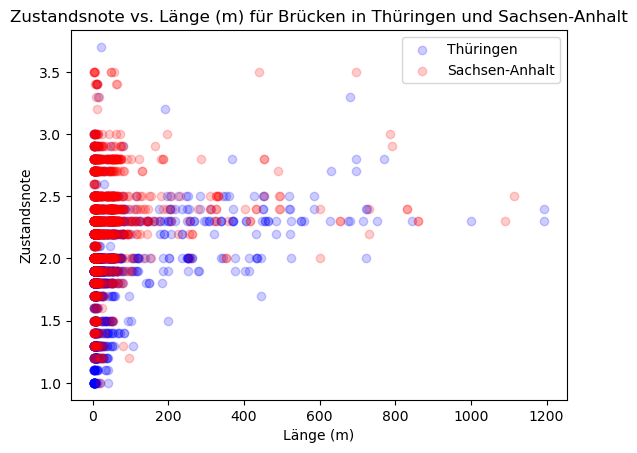

Thüringen - Kürzeste Brücke: 2.05 m, Längste Brücke: 1194.4 m
Sachsen-Anhalt - Kürzeste Brücke: 2.15 m, Längste Brücke: 1115.0 m


In [30]:
# print Zustandsnote ~ Länge (m)
plt.scatter(data_thueringen['Länge (m)'], data_thueringen['Zustandsnote'], color='blue', label='Thüringen', alpha=0.2)
plt.scatter(data_sachsen_anhalt['Länge (m)'], data_sachsen_anhalt['Zustandsnote'], color='red', label='Sachsen-Anhalt', alpha=0.2)
plt.xlabel('Länge (m)')
plt.ylabel('Zustandsnote')
plt.title('Zustandsnote vs. Länge (m) für Brücken in Thüringen und Sachsen-Anhalt')
plt.legend()
plt.show()

# print which state has the smallest and longest bridge
min_length_thueringen = data_thueringen['Länge (m)'].min()
max_length_thueringen = data_thueringen['Länge (m)'].max()
min_length_sachsen_anhalt = data_sachsen_anhalt['Länge (m)'].min()
max_length_sachsen_anhalt = data_sachsen_anhalt['Länge (m)'].max()
print(f"Thüringen - Kürzeste Brücke: {min_length_thueringen} m, Längste Brücke: {max_length_thueringen} m")
print(f"Sachsen-Anhalt - Kürzeste Brücke: {min_length_sachsen_anhalt} m, Längste Brücke: {max_length_sachsen_anhalt} m")

##### Motorway/Federal Road vs. Condition

There is no big difference between Motorway (A) and Federal Road (B) with respect to the condition within one state. The average condition is just shifted when comparing `Thüringen` and `Sachsen-Anhalt` independent of the type of the road. 

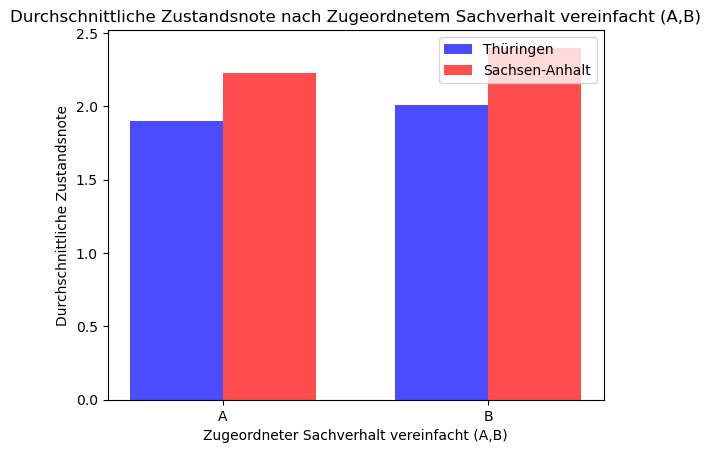

In [31]:
# print Zustandsnote ~ Zugeordneter Sachverhalt vereinfacht (A,B)
data_thueringen_grouped = data_thueringen.groupby('Zugeordneter Sachverhalt vereinfacht')['Zustandsnote'].mean()
data_sachsen_anhalt_grouped = data_sachsen_anhalt.groupby('Zugeordneter Sachverhalt vereinfacht')['Zustandsnote'].mean()
labels = data_thueringen_grouped.index.tolist()
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars   
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, data_thueringen_grouped, width, label='Thüringen', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, data_sachsen_anhalt_grouped, width, label='Sachsen-Anhalt', color='red', alpha=0.7)
ax.set_xlabel('Zugeordneter Sachverhalt vereinfacht (A,B)')
ax.set_ylabel('Durchschnittliche Zustandsnote')
ax.set_title('Durchschnittliche Zustandsnote nach Zugeordnetem Sachverhalt vereinfacht (A,B)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

##### GDP vs. Condition

There is no clear correlation between GDP and the condition of the bridges within those district. Higher GDP does not lead to a lower condition. 

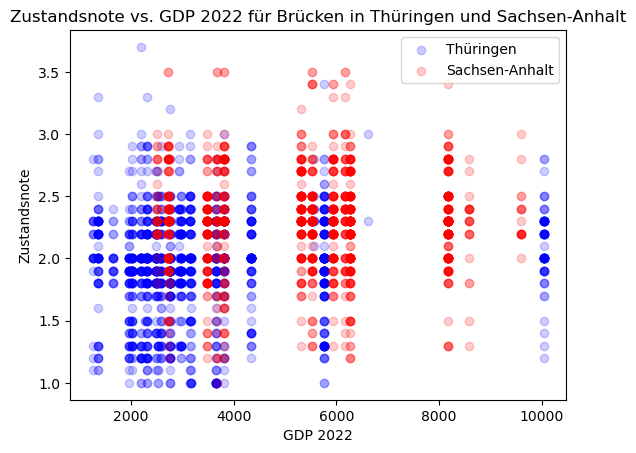

In [32]:
# plot Zustandsnote ~ GDP 2022
plt.scatter(data_thueringen['GDP 2022'], data_thueringen['Zustandsnote'], color='blue', label='Thüringen', alpha=0.2)
plt.scatter(data_sachsen_anhalt['GDP 2022'], data_sachsen_anhalt['Zustandsnote'], color='red', label='Sachsen-Anhalt', alpha=0.2)
plt.xlabel('GDP 2022')
plt.ylabel('Zustandsnote')
plt.title('Zustandsnote vs. GDP 2022 für Brücken in Thüringen und Sachsen-Anhalt')
plt.legend()
plt.show()

##### Material pestressed concrete vs. Condition

The amount of bridged built with pestressed concrete (Spannbeton) in both states is rather similar (520 vs. 578). However, the average condition is shifted when looking at `Thüringen` and `Sachsen-Anhalt` and all pestressed concrete bridges. The same accounts for all bridges not build from pestressed concrete. 

In [33]:
# analysis of bridges with Baustoffklasse Spannbeton
data_thueringen_spannbeton = data_thueringen[data_thueringen['Baustoffklasse'] == 'Spannbeton']
data_sachsen_anhalt_spannbeton = data_sachsen_anhalt[data_sachsen_anhalt['Baustoffklasse'] == 'Spannbeton']

# print amount of bridges + percentage
print(f"Number of bridges with Baustoffklasse (building materials class) Spannbeton (prestressed concrete) in Thüringen: {len(data_thueringen_spannbeton)} ({len(data_thueringen_spannbeton) / len(data_thueringen) * 100:.2f}%)")
print(f"Number of bridges with Baustoffklasse (building materials class) Spannbeton (prestressed concrete) in Sachsen-Anhalt: {len(data_sachsen_anhalt_spannbeton)} ({len(data_sachsen_anhalt_spannbeton) / len(data_sachsen_anhalt) * 100:.2f}%)")

# print average Zustandsnote for Spannbeton bridges
avg_zustandsnote_thueringen_spannbeton = data_thueringen_spannbeton['Zustandsnote'].mean()
avg_zustandsnote_sachsen_anhalt_spannbeton = data_sachsen_anhalt_spannbeton['Zustandsnote'].mean()
print(f"\n Average Zustandsnote (condition score) for Spannbeton (prestressed concrete) bridges in Thüringen: {avg_zustandsnote_thueringen_spannbeton:.2f}")
print(f"Average Zustandsnote (condition score) for Spannbeton (prestressed concrete) bridges in Sachsen-Anhalt: {avg_zustandsnote_sachsen_anhalt_spannbeton:.2f}")

# print average Zustandsnote for non-Spannbeton bridges
data_thueringen_non_spannbeton = data_thueringen[data_thueringen['Baustoffklasse'] != 'Spannbeton']
data_sachsen_anhalt_non_spannbeton = data_sachsen_anhalt[data_sachsen_anhalt['Baustoffklasse'] != 'Spannbeton']
avg_zustandsnote_thueringen_non_spannbeton = data_thueringen_non_spannbeton['Zustandsnote'].mean()  
avg_zustandsnote_sachsen_anhalt_non_spannbeton = data_sachsen_anhalt_non_spannbeton['Zustandsnote'].mean()
print(f"\nAverage Zustandsnote (condition score) for non-Spannbeton (non-prestressed concrete) bridges in Thüringen: {avg_zustandsnote_thueringen_non_spannbeton:.2f}")
print(f"Average Zustandsnote (condition score) for non-Spannbeton (non-prestressed concrete) bridges in Sachsen-Anhalt: {avg_zustandsnote_sachsen_anhalt_non_spannbeton:.2f}")

Number of bridges with Baustoffklasse (building materials class) Spannbeton (prestressed concrete) in Thüringen: 520 (30.11%)
Number of bridges with Baustoffklasse (building materials class) Spannbeton (prestressed concrete) in Sachsen-Anhalt: 578 (40.42%)

 Average Zustandsnote (condition score) for Spannbeton (prestressed concrete) bridges in Thüringen: 2.07
Average Zustandsnote (condition score) for Spannbeton (prestressed concrete) bridges in Sachsen-Anhalt: 2.38

Average Zustandsnote (condition score) for non-Spannbeton (non-prestressed concrete) bridges in Thüringen: 1.89
Average Zustandsnote (condition score) for non-Spannbeton (non-prestressed concrete) bridges in Sachsen-Anhalt: 2.24


##### Correlation of numerical features

The correlation matrix (using pearson correlation) shows that there is no significant difference between `Thüringen` and `Sachsen-Anhalt` with respect to the correlation of individual features. 

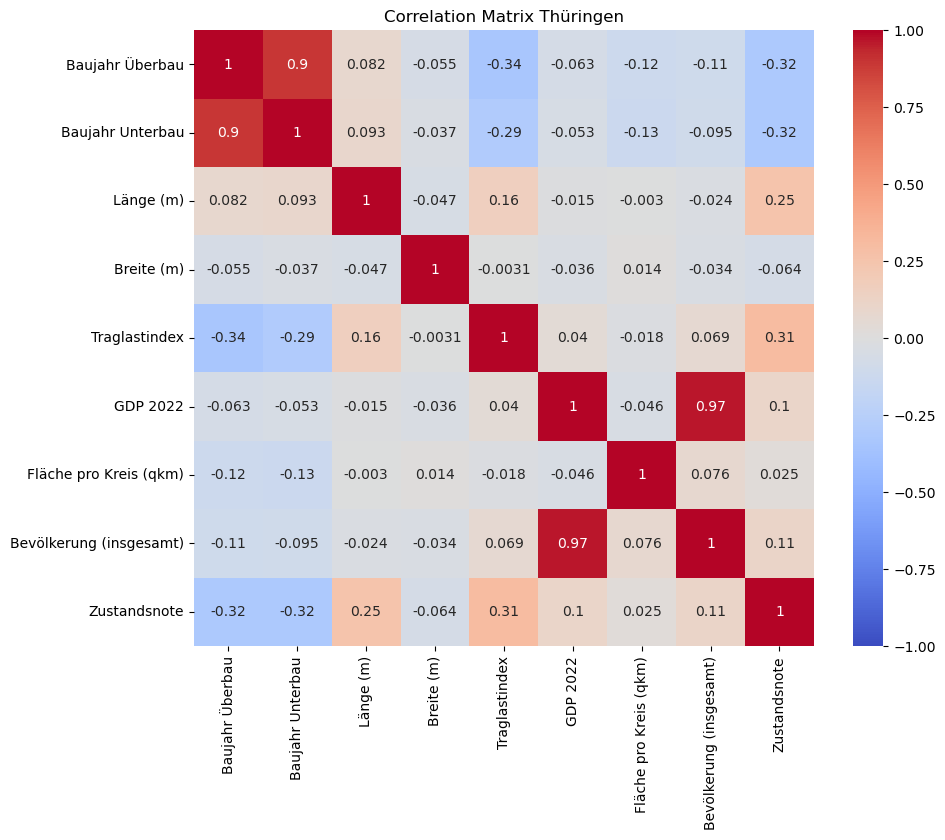

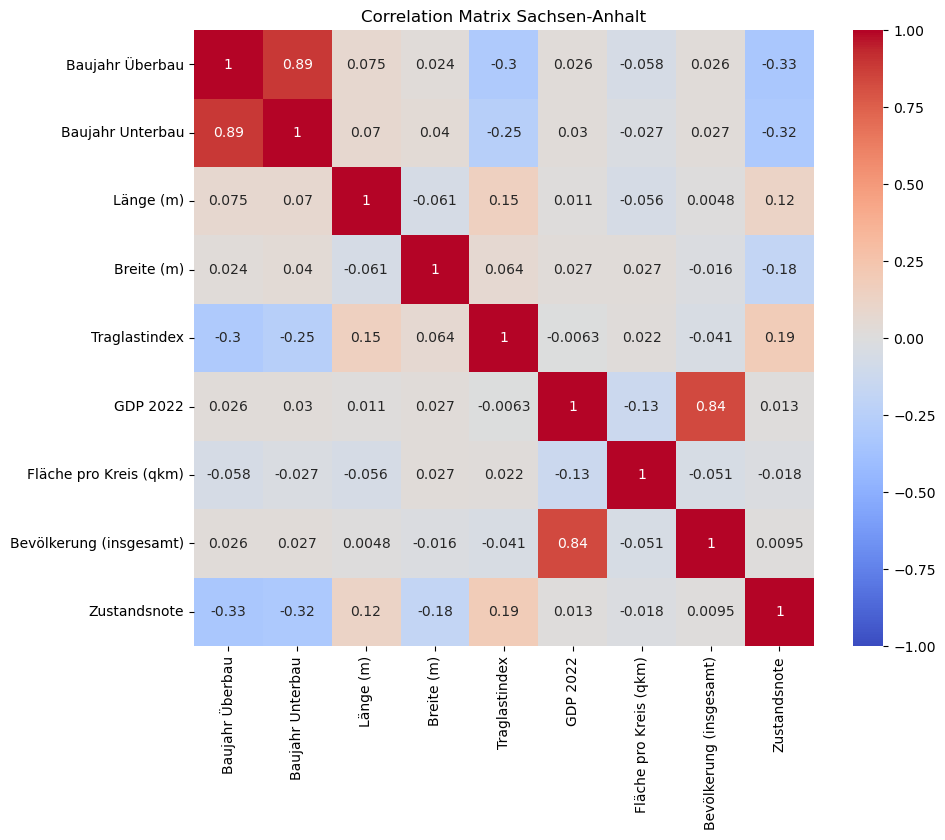

In [34]:
# list of numerical features
num_features = [
    'Baujahr Überbau', 'Baujahr Unterbau', 'Länge (m)', 'Breite (m)',
    'Traglastindex', 'GDP 2022', 'Fläche pro Kreis (qkm)', 'Bevölkerung (insgesamt)', 'Zustandsnote'
]

# Heatmap for Thüringen
corr_th = data_thueringen[num_features].corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(corr_th, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Thüringen')
plt.show()

# Heatmap for Sachsen-Anhalt
corr_sa = data_sachsen_anhalt[num_features].corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(corr_sa, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Sachsen-Anhalt')
plt.show()

##### Random Forest

In [3]:
# function to perform random forest analysis and plot shapley values
# @param data: DataFrame containing the dataset
# @param target: target variable name as string
# @return: None
def random_forest_shapley_analysis(data, target):
    X = data.drop(columns=[target])
    y = data[target]

    # transform categorical variables using one-hot encoding
    X = pd.get_dummies(X, columns=['Baustoffklasse', 'Baustoff Überbau', 'Zugeordneter Sachverhalt', 'Zugeordneter Sachverhalt vereinfacht', 'Teilbauwerksstadium', 'Teilbauwerksart', 'Kreis'], drop_first=True)

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

    # scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'max_features': ['sqrt', 'log2', None]
    }

    # train random forest regressor
    rf = RandomForestRegressor(random_state=4)
    grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    # print parameters and evaluate model
    print("Best parameters:", grid_search.best_params_)
    rf_best = grid_search.best_estimator_
    rf_best.fit(X_train_scaled, y_train)
    print(f"Random Forest R^2 Score: {rf_best.score(X_test_scaled, y_test):.4f}")
    y_pred = rf_best.predict(X_test_scaled)
    mse = np.mean((y_test - y_pred) ** 2)
    print(f"Random Forest MSE: {mse:.4f}")

    # calculate shapley values (use TreeExplainer and rf_best)
    explainer = shap.TreeExplainer(rf_best)
    shap_values = explainer.shap_values(X_test_scaled)

    return shap_values, X_test, rf_best, X_train, X

# perform analysis for Thüringen
print("Random Forest Analysis for Thüringen:")
data_thueringen_processed = data_thueringen.drop(columns=['Bundeslandname', 'Bauwerksname', 'Unnamed: 0', 'X', 'Y'])
shap_values, X_test, rf_best, X_train, X = random_forest_shapley_analysis(data_thueringen_processed, 'Zustandsnote')

# perform analysis for Sachsen-Anhalt
print("Random Forest Analysis for Sachsen-Anhalt:")
data_sachsen_anhalt_processed = data_sachsen_anhalt.drop(columns=['Bundeslandname', 'Bauwerksname', 'Unnamed: 0', 'X', 'Y'])
shap_values_s, X_test_s, rf_best_s, X_train_s, X_s = random_forest_shapley_analysis(data_sachsen_anhalt_processed, 'Zustandsnote')
    

Random Forest Analysis for Thüringen:
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Random Forest R^2 Score: 0.4675
Random Forest MSE: 0.0919
Random Forest Analysis for Sachsen-Anhalt:
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Random Forest R^2 Score: 0.4245
Random Forest MSE: 0.0773


Shapley Values and Feature Importance Plots for Thüringen:


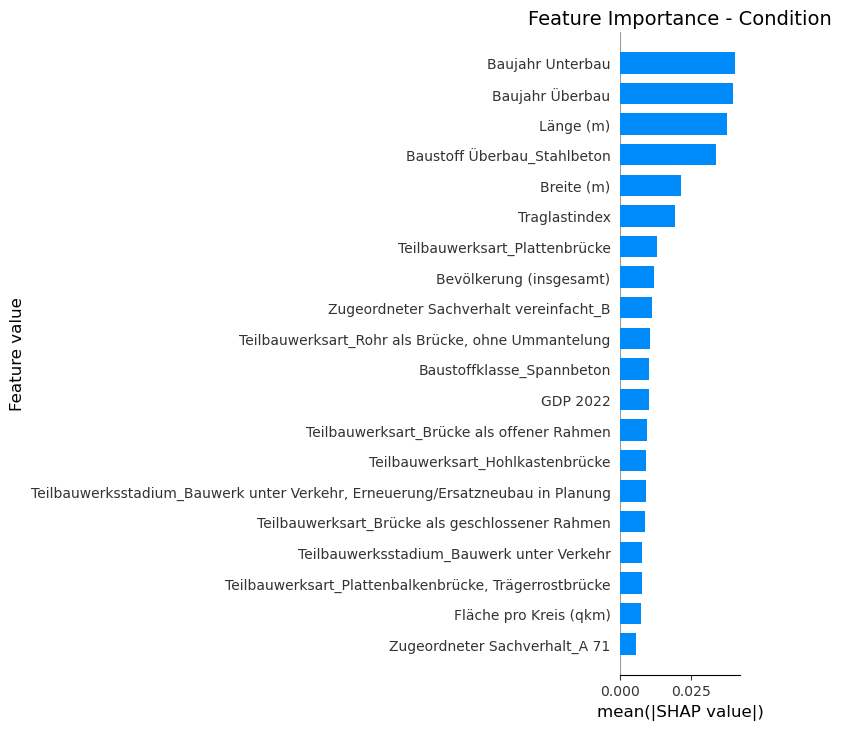

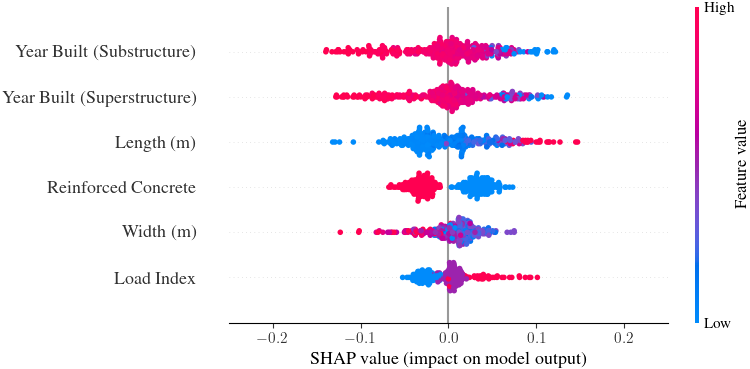

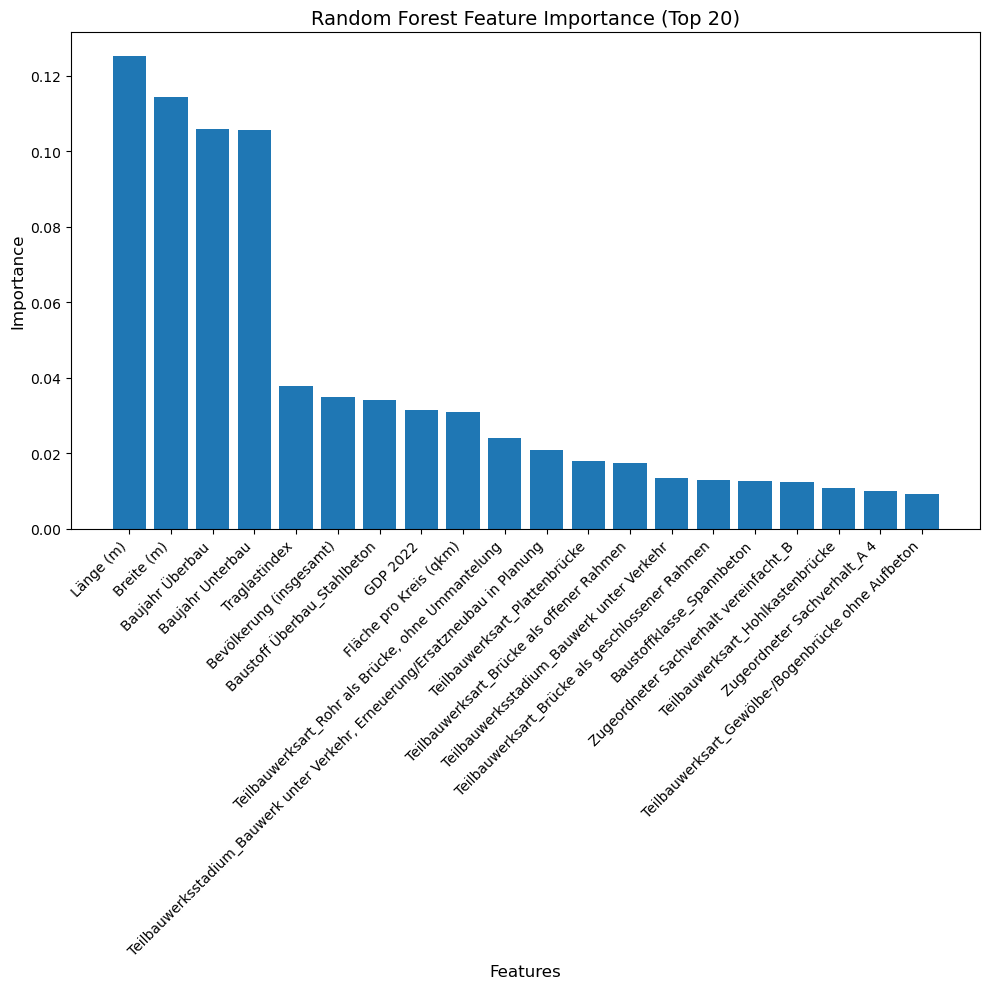


Shapley Values and Feature Importance Plots for Sachsen-Anhalt:


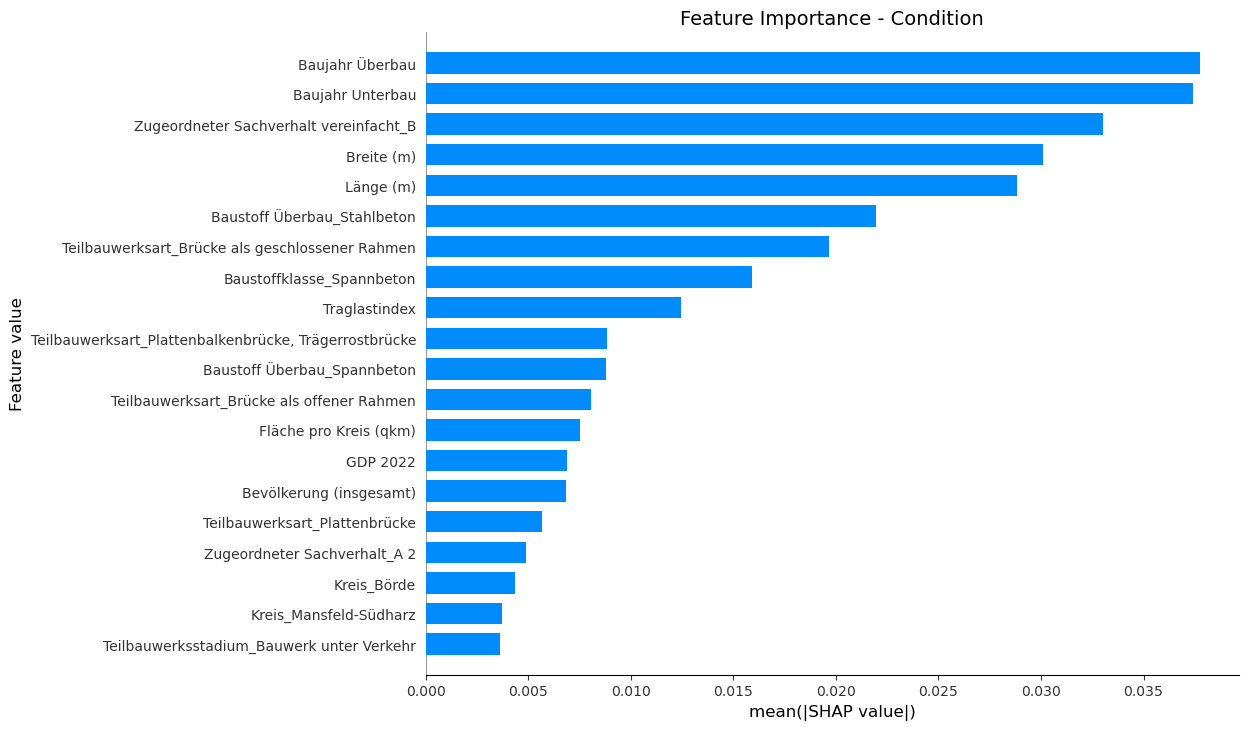

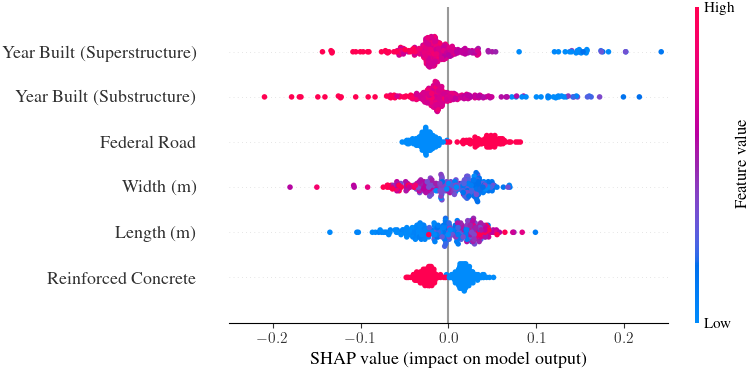

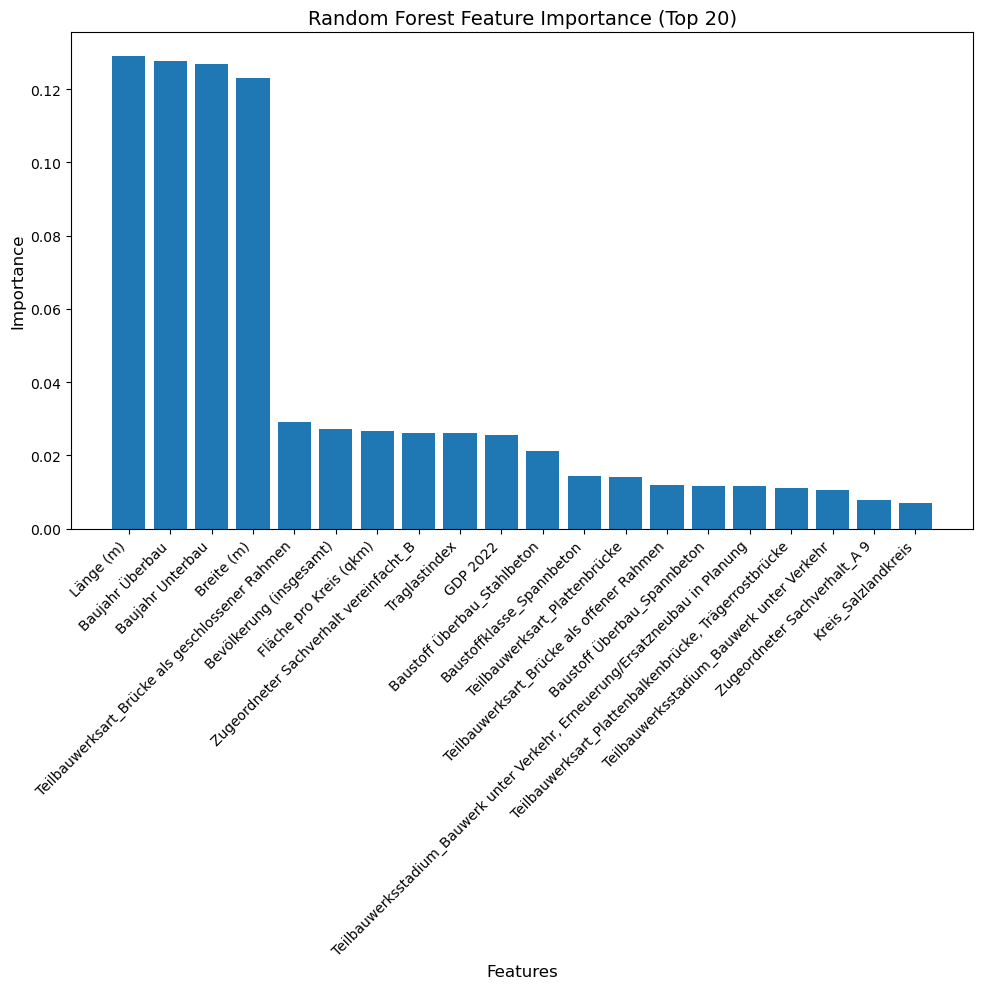

In [42]:
# function to plot feature importance from random forest
# @param rf_best: trained RandomForestRegressor model
# @param X_train: training feature set
# @param X: full feature set
# @return: None
def plot_importance(rf_best, X_train, X):

    mpl.rcdefaults()

    # plot feature importance (not based on shapley values)
    importances = rf_best.feature_importances_
    feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else X.columns

    # sort features by importance
    indices = np.argsort(importances)[::-1][:20]  # only top 20
    plt.figure(figsize=(10, 10))
    plt.title("Random Forest Feature Importance (Top 20)", fontsize=14)
    plt.bar(range(len(indices)), importances[indices], align="center")

    # rotate x-axis labels for better readability (45 degrees)
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Importance", fontsize=12)
    plt.tight_layout()
    plt.show()

    return 

# function to plot overall mean shapley value per feature
# @param shap_values: shapley values array
# @param X_test: test feature set
# @param R: boolean value whether resize figure
# @return: None
def plot_overall_shapley(shap_values, X_test, R):

    mpl.rcdefaults()

    # plot shapley values - bar plot
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    # get the current figure and axes objects
    fig, ax = plt.gcf(), plt.gca()

    # modifying main plot parameters
    ax.tick_params(labelsize=10)
    ax.set_xlabel("mean(|SHAP value|)", fontsize=12)
    ax.set_title('Feature Importance - Condition', fontsize=14)

    # get colorbar
    cb_ax = fig.axes[0] 

    # modifying color bar parameters
    cb_ax.tick_params(labelsize=10)
    cb_ax.set_ylabel("Feature value", fontsize=12)

    # make plot wider
    if R: 
        fig.set_size_inches(25, 7)
    else: 
        fig.set_size_inches(150, 7)
    plt.show()

# function to plot shapley values summary plot
# @param shap_values: shapley values array
# @param X_test: test feature set
# @param feature_names: list of feature names
# @param filename: filename to save the plot
# @return: None
def plot_shapley_values(shap_values, X_test, feature_names=None, filename="SHAP.png"):

    # set color stylesheet
    plt.rcParams.update(bundles.icml2024(column="half", nrows=1, ncols=1))
    # reset constrained layout to avoid error wrt SHAP plot
    mpl.rcParams['figure.constrained_layout.use'] = mpl.rcParamsDefault['figure.constrained_layout.use']

    fig, ax = plt.subplots() 

    # plot shapley values - summary plot
    shap.summary_plot(shap_values, X_test, max_display=6, feature_names=feature_names, show=False)

    # adjust range of x-axis
    ax.set_xlim(-0.25, 0.25)

    plt.show()
    # save plots as png
    # plt.savefig(filename)
    plt.close(fig)
    return

print("Shapley Values and Feature Importance Plots for Thüringen:")
feature_names = ['Year Built (Superstructure)', 'Year Built (Substructure)', 'Length (m)', 'Width (m)', 'Load Index', 'GDP 2022', 'Fläche pro Kreis (qkm)', 'Bevölkerung (insgesamt)', 'Baustoffklasse_Spannbeton', 'Baustoffklasse_Stahl/Leichtmetall', 'Baustoffklasse_Stahlverbund', 'Baustoffklasse_Stein', 'Baustoff Überbau_Künstlicher Stein', 'Baustoff Überbau_Naturstein', 'Baustoff Überbau_Schweißprofil', 'Baustoff Überbau_Spannbeton', 'Baustoff Überbau_Spannbetonfertigteile mit Ortbeton', 'Baustoff Überbau_Spannbetonfertigteile mit Ortbeton im Verbund', 'Baustoff Überbau_Spannbetonfertigteile mit Ortbeton ohne Verbund', 'Baustoff Überbau_Stahl', 'Baustoff Überbau_Stahl - Beton', 'Reinforced Concrete', 'Baustoff Überbau_Stahlbetonfertigteile mit Ortbeton', 'Baustoff Überbau_Stahlbetonfertigteile mit Ortbeton im Verbund', 'Baustoff Überbau_Stahlbetonfertigteile mit Ortbeton ohne Verbund', 'Baustoff Überbau_Stahltragwerk mit Betonfertigteilen im Verbund', 'Baustoff Überbau_Stahltragwerk mit Betonplatte im Verbund', 'Baustoff Überbau_Unbewehrter Beton', 'Baustoff Überbau_Walzträger in Beton', 'Baustoff Überbau_Wellprofil', 'Zugeordneter Sachverhalt_A 4', 'Zugeordneter Sachverhalt_A 4  (Ast)', 'Zugeordneter Sachverhalt_A 4 R (Ast)', 'Zugeordneter Sachverhalt_A 71', 'Zugeordneter Sachverhalt_A 71  (Ast)', 'Zugeordneter Sachverhalt_A 73', 'Zugeordneter Sachverhalt_A 9', 'Zugeordneter Sachverhalt_B 175', 'Zugeordneter Sachverhalt_B 176', 'Zugeordneter Sachverhalt_B 180', 'Zugeordneter Sachverhalt_B 19', 'Zugeordneter Sachverhalt_B 19  (Ast)', 'Zugeordneter Sachverhalt_B 2', 'Zugeordneter Sachverhalt_B 243', 'Zugeordneter Sachverhalt_B 247', 'Zugeordneter Sachverhalt_B 247  (Ast)', 'Zugeordneter Sachverhalt_B 249', 'Zugeordneter Sachverhalt_B 250', 'Zugeordneter Sachverhalt_B 278', 'Zugeordneter Sachverhalt_B 281', 'Zugeordneter Sachverhalt_B 285', 'Zugeordneter Sachverhalt_B 4', 'Zugeordneter Sachverhalt_B 4  (Ast)', 'Zugeordneter Sachverhalt_B 62', 'Zugeordneter Sachverhalt_B 7', 'Zugeordneter Sachverhalt_B 80', 'Zugeordneter Sachverhalt_B 81', 'Zugeordneter Sachverhalt_B 84', 'Zugeordneter Sachverhalt_B 85', 'Zugeordneter Sachverhalt_B 86', 'Zugeordneter Sachverhalt_B 87', 'Zugeordneter Sachverhalt_B 88', 'Zugeordneter Sachverhalt_B 88  (Ast)', 'Zugeordneter Sachverhalt_B 89', 'Zugeordneter Sachverhalt_B 90', 'Zugeordneter Sachverhalt_B 92', 'Zugeordneter Sachverhalt_B 93', 'Zugeordneter Sachverhalt_B 94', 'Zugeordneter Sachverhalt vereinfacht_B', 'Teilbauwerksstadium_Bauwerk unter Verkehr', 'Teilbauwerksstadium_Bauwerk unter Verkehr, Erneuerung/Ersatzneubau in Planung', 'Teilbauwerksstadium_Bauwerk unter Verkehr, Instandsetzung in Planung', 'Teilbauwerksstadium_Bauwerk unter Verkehr, Instandsetzung in der Ausführung', 'Teilbauwerksstadium_Bauwerk unter Verkehr, Um- und Ausbau in Planung', 'Teilbauwerksstadium_Bauwerk unter Verkehr, Umstufung in der Vorbereitung', 'Teilbauwerksstadium_Neubau fertig gestellt, nicht unter Verkehr', 'Teilbauwerksart_Bogenbrücke als Mischsystem', 'Teilbauwerksart_Bogenbrücke mit abgehängter Fahrbahn', 'Teilbauwerksart_Bogenbrücke mit aufgeständerter Fahrbahn', 'Teilbauwerksart_Brücke als Rahmen-Mischsystem', 'Teilbauwerksart_Brücke als Schrägstielrahmen', 'Teilbauwerksart_Brücke als geschlossener Rahmen', 'Teilbauwerksart_Brücke als offener Rahmen', 'Teilbauwerksart_Brücke mit Balken- / Plattenmischsystem', 'Teilbauwerksart_Brücke mit einer speziellen Rahmenkonstruktionen', 'Teilbauwerksart_Gewölbe- bzw. Bogenbrücke', 'Teilbauwerksart_Gewölbe-/Bogenbrücke mit Aufbeton im Verbund', 'Teilbauwerksart_Gewölbe-/Bogenbrücke mit Aufbeton ohne Verbund', 'Teilbauwerksart_Gewölbe-/Bogenbrücke mit Lastverteilungsplatte', 'Teilbauwerksart_Gewölbe-/Bogenbrücke ohne Aufbeton', 'Teilbauwerksart_Hohlkastenbrücke', 'Teilbauwerksart_Plattenbalkenbrücke, Trägerrostbrücke', 'Teilbauwerksart_Plattenbrücke', 'Teilbauwerksart_Rahmenbrücke als Trog-Haube-Konstruktion', 'Teilbauwerksart_Rohr als Brücke, mit Ummantelung', 'Teilbauwerksart_Rohr als Brücke, ohne Ummantelung', 'Teilbauwerksart_Trogbrücke', 'Kreis_Eichsfeld', 'Kreis_Erfurt', 'Kreis_Gera', 'Kreis_Gotha', 'Kreis_Greiz', 'Kreis_Hersfeld-Rotenburg', 'Kreis_Hildburghausen', 'Kreis_Ilm-Kreis', 'Kreis_Jena', 'Kreis_Kyffhäuserkreis', 'Kreis_Mansfeld-Südharz', 'Kreis_Nordhausen', 'Kreis_Saale-Holzland-Kreis', 'Kreis_Saale-Orla-Kreis', 'Kreis_Saalfeld-Rudolstadt', 'Kreis_Schmalkalden-Meiningen', 'Kreis_Sonneberg', 'Kreis_Suhl', 'Kreis_Sömmerda', 'Kreis_Unstrut-Hainich-Kreis', 'Kreis_Vogtlandkreis', 'Kreis_Wartburgkreis', 'Kreis_Weimar', 'Kreis_Weimarer Land', 'Kreis_Werra-Meißner-Kreis']
plot_overall_shapley(shap_values, X_test, False)
plot_shapley_values(shap_values, X_test, feature_names, "../plots_for_report/SHAP_Thüringen.pdf")
plot_importance(rf_best, X_train, X)

print("\nShapley Values and Feature Importance Plots for Sachsen-Anhalt:")
feature_names_s = ['Year Built (Superstructure)', 'Year Built (Substructure)', 'Length (m)', 'Width (m)', 'Load Index', 'GDP 2022', 'Fläche pro Kreis (qkm)', 'Bevölkerung (insgesamt)', 'Baustoffklasse_Spannbeton', 'Baustoffklasse_Stahl/Leichtmetall', 'Baustoffklasse_Stahlverbund', 'Baustoffklasse_Stein', 'Baustoff Überbau_Geschweißtes Hohlprofil', 'Baustoff Überbau_Künstlicher Stein', 'Baustoff Überbau_Naturstein', 'Baustoff Überbau_Schweißprofil', 'Baustoff Überbau_Spannbeton', 'Baustoff Überbau_Spannbetonfertigteile mit Ortbeton', 'Baustoff Überbau_Spannbetonfertigteile mit Ortbeton im Verbund', 'Baustoff Überbau_Spannbetonfertigteile mit Ortbeton ohne Verbund', 'Baustoff Überbau_Stahl', 'Baustoff Überbau_Stahl - Beton', 'Reinforced Concrete', 'Baustoff Überbau_Stahlbetonfertigteile mit Ortbeton', 'Baustoff Überbau_Stahlbetonfertigteile mit Ortbeton im Verbund', 'Baustoff Überbau_Stahlbetonfertigteile mit Ortbeton ohne Verbund', 'Baustoff Überbau_Stahltragwerk mit Betonfertigteilen im Verbund', 'Baustoff Überbau_Stahltragwerk mit Betonplatte im Verbund', 'Baustoff Überbau_Unbewehrter Beton', 'Baustoff Überbau_Walzträger in Beton', 'Baustoff Überbau_Wellprofil', 'Zugeordneter Sachverhalt_A 14  (Ast)', 'Zugeordneter Sachverhalt_A 143', 'Zugeordneter Sachverhalt_A 2', 'Zugeordneter Sachverhalt_A 36', 'Zugeordneter Sachverhalt_A 38', 'Zugeordneter Sachverhalt_A 71', 'Zugeordneter Sachverhalt_A 9', 'Zugeordneter Sachverhalt_A 9  (Ast)', 'Zugeordneter Sachverhalt_B 1', 'Zugeordneter Sachverhalt_B 100', 'Zugeordneter Sachverhalt_B 107', 'Zugeordneter Sachverhalt_B 176', 'Zugeordneter Sachverhalt_B 180', 'Zugeordneter Sachverhalt_B 180 N', 'Zugeordneter Sachverhalt_B 181', 'Zugeordneter Sachverhalt_B 182', 'Zugeordneter Sachverhalt_B 183', 'Zugeordneter Sachverhalt_B 183 A', 'Zugeordneter Sachverhalt_B 184', 'Zugeordneter Sachverhalt_B 185', 'Zugeordneter Sachverhalt_B 187', 'Zugeordneter Sachverhalt_B 187 A', 'Zugeordneter Sachverhalt_B 188', 'Zugeordneter Sachverhalt_B 189', 'Zugeordneter Sachverhalt_B 190', 'Zugeordneter Sachverhalt_B 2', 'Zugeordneter Sachverhalt_B 242', 'Zugeordneter Sachverhalt_B 244', 'Zugeordneter Sachverhalt_B 245', 'Zugeordneter Sachverhalt_B 245 A', 'Zugeordneter Sachverhalt_B 246', 'Zugeordneter Sachverhalt_B 246 A', 'Zugeordneter Sachverhalt_B 248', 'Zugeordneter Sachverhalt_B 250', 'Zugeordneter Sachverhalt_B 27', 'Zugeordneter Sachverhalt_B 6', 'Zugeordneter Sachverhalt_B 71', 'Zugeordneter Sachverhalt_B 71  (Ast)', 'Zugeordneter Sachverhalt_B 79', 'Zugeordneter Sachverhalt_B 80', 'Zugeordneter Sachverhalt_B 81', 'Zugeordneter Sachverhalt_B 85', 'Zugeordneter Sachverhalt_B 86', 'Zugeordneter Sachverhalt_B 87', 'Zugeordneter Sachverhalt_B 91', 'Federal Road', 'Teilbauwerksstadium_BW nicht unter Verkehr, Erneuerung/Ersatzneubau in der Ausführung', 'Teilbauwerksstadium_Bauwerk unter Verkehr', 'Teilbauwerksstadium_Bauwerk unter Verkehr, Erneuerung/Ersatzneubau in Planung', 'Teilbauwerksstadium_Bauwerk unter Verkehr, Instandsetzung in Planung', 'Teilbauwerksstadium_Bauwerk unter Verkehr, Instandsetzung in der Ausführung', 'Teilbauwerksart_Bogenbrücke als Mischsystem', 'Teilbauwerksart_Bogenbrücke mit abgehängter Fahrbahn', 'Teilbauwerksart_Bogenbrücke mit aufgeständerter Fahrbahn', 'Teilbauwerksart_Brücke', 'Teilbauwerksart_Brücke als Rahmen-Mischsystem', 'Teilbauwerksart_Brücke als Schrägstielrahmen', 'Teilbauwerksart_Brücke als geschlossener Rahmen', 'Teilbauwerksart_Brücke als offener Rahmen', 'Teilbauwerksart_Brücke mit Balken- / Plattenmischsystem', 'Teilbauwerksart_Brücke mit balkenartigem oder plattenartigem Tragwerk', 'Teilbauwerksart_Brücke mit einer speziellen Rahmenkonstruktionen', 'Teilbauwerksart_Gewölbe- bzw. Bogenbrücke', 'Teilbauwerksart_Gewölbe-/Bogenbrücke mit Aufbeton im Verbund', 'Teilbauwerksart_Gewölbe-/Bogenbrücke mit Lastverteilungsplatte', 'Teilbauwerksart_Gewölbe-/Bogenbrücke ohne Aufbeton', 'Teilbauwerksart_Hohlkastenbrücke', 'Teilbauwerksart_Plattenbalkenbrücke, Trägerrostbrücke', 'Teilbauwerksart_Plattenbrücke', 'Teilbauwerksart_Rahmenbrücke', 'Teilbauwerksart_Rahmenbrücke als Trog-Haube-Konstruktion', 'Teilbauwerksart_Rohr als Brücke, mit Ummantelung', 'Teilbauwerksart_Rohr als Brücke, ohne Ummantelung', 'Teilbauwerksart_Schrägseilbrücke, Büschelsystem', 'Teilbauwerksart_Schrägseilbrücke, Harfensystem', 'Teilbauwerksart_Trogbrücke', 'Kreis_Anhalt-Bitterfeld', 'Kreis_Burgenlandkreis', 'Kreis_Börde', 'Kreis_Dessau-Roßlau', 'Kreis_Halle (Saale)', 'Kreis_Harz', 'Kreis_Jerichower Land', 'Kreis_Magdeburg', 'Kreis_Mansfeld-Südharz', 'Kreis_Saalekreis', 'Kreis_Salzlandkreis', 'Kreis_Stendal', 'Kreis_Wittenberg']
plot_overall_shapley(shap_values_s, X_test_s, True)
plot_shapley_values(shap_values_s, X_test_s, feature_names_s, "../plots_for_report/SHAP_Sachsen_Anhalt.pdf")
plot_importance(rf_best_s, X_train_s, X_s)